# Purpose:

To address the activities in the coding exercise (https://8weeksqlchallenge.com/case-study-2/) as an example of SQL queries. 


## Introduction

Danny was scrolling through his Instagram feed when something really caught his eye - “80s Retro Styling and Pizza Is The Future!”

Danny was sold on the idea, but he knew that pizza alone was not going to help him get seed funding to expand his new Pizza Empire - so he had one more genius idea to combine with it - he was going to Uberize it - and so Pizza Runner was launched!

Danny started by recruiting “runners” to deliver fresh pizza from Pizza Runner Headquarters (otherwise known as Danny’s house) and also maxed out his credit card to pay freelance developers to build a mobile app to accept orders from customers.

## Available Data
Because Danny had a few years of experience as a data scientist - he was very aware that data collection was going to be critical for his business’ growth.

He has prepared for us an entity relationship diagram of his database design but requires further assistance to clean his data and apply some basic calculations so he can better direct his runners and optimise Pizza Runner’s operations.

All datasets exist within the pizza_runner database schema - be sure to include this reference within your SQL scripts as you start exploring the data and answering the case study questions.

# Load Libraries

In [193]:
import os
import psycopg2
from psycopg2 import sql
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Connect to local PostgreSQL Database

In [252]:
# Retrieve environment variables
dbname = os.getenv("DB_NAME")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST", "localhost")
port = os.getenv("DB_PORT", "5432")
schema = os.getenv("DB_SCHEMA", "pizza_runner")

# Establish a connection
connection = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)
cursor = connection.cursor()
cursor.execute("SELECT version();")
print(cursor.fetchone())

# Set the schema
cursor.execute(sql.SQL("SET search_path TO {}").format(sql.Identifier(schema)))

('PostgreSQL 16.3 (Homebrew) on aarch64-apple-darwin23.4.0, compiled by Apple clang version 15.0.0 (clang-1500.3.9.4), 64-bit',)


In [4]:
# Test connection with a simple query
cursor.execute(sql.SQL("SELECT * FROM runner_orders LIMIT 5;"))
cursor.fetchall()

[(1, 1, '2020-01-01 18:15:34', '20km', '32 minutes', ''),
 (2, 1, '2020-01-01 19:10:54', '20km', '27 minutes', ''),
 (3, 1, '2020-01-03 00:12:37', '13.4km', '20 mins', None),
 (4, 2, '2020-01-04 13:53:03', '23.4', '40', None),
 (5, 3, '2020-01-08 21:10:57', '10', '15', None)]

# Questions from Client

This case study has LOTS of questions - they are broken up by area of focus including:

Pizza Metrics
Runner and Customer Experience
Ingredient Optimisation
Pricing and Ratings
Bonus DML Challenges (DML = Data Manipulation Language)
Each of the following case study questions can be answered using a single SQL statement.

Again, there are many questions in this case study - please feel free to pick and choose which ones you’d like to try!



---
## A. Pizza Metrics
How many pizzas were ordered?

In [113]:
query = """
    SELECT COUNT(*) FROM customer_orders;
    """

cursor.execute(sql.SQL(query))
num_pizzas_ordered = cursor.fetchall()[0][0]
print(f"A total of {num_pizzas_ordered} pizzas have been ordered.")

A total of 14 pizzas have been ordered.


How many unique customer orders were made?

In [114]:
query = """
    SELECT * FROM runner_orders
    WHERE (cancellation NOT LIKE '%Cancellation%' 
        OR cancellation IS NULL);
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

orders_made_df = pd.DataFrame(sql_table, columns=column_names)

# Note: This can also be done by counting the number of rows in the pandas dataframe, but
    # the purpose of the exercise is to do it in SQL.
query = """
    SELECT COUNT(*) FROM runner_orders
    WHERE (cancellation NOT LIKE '%Cancellation%' 
        OR cancellation IS NULL);
    """

cursor.execute(sql.SQL(query))
order_count = cursor.fetchone()[0]
print(f"A total of {order_count} orders have been made.")
orders_made_df

A total of 8 orders have been made.


,order_id,runner_id,pickup_time,distance,duration,cancellation
0,1,1,2020-01-01 18:15:34,20km,32 minutes,
1,2,1,2020-01-01 19:10:54,20km,27 minutes,
2,3,1,2020-01-03 00:12:37,13.4km,20 mins,None
3,4,2,2020-01-04 13:53:03,23.4,40,None
4,5,3,2020-01-08 21:10:57,10,15,None
5,7,2,2020-01-08 21:30:45,25km,25mins,null
6,8,2,2020-01-10 00:15:02,23.4 km,15 minute,null
7,10,1,2020-01-11 18:50:20,10km,10minutes,null


How many successful orders were delivered by each runner?


In [115]:
query = """
    SELECT ro.runner_id, COUNT(ro.order_id) AS tot_orders_deliv FROM runner_orders AS ro
    WHERE (cancellation NOT LIKE '%Cancellation%' 
        OR cancellation IS NULL)
    GROUP BY ro.runner_id;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

orders_deliv_df = pd.DataFrame(sql_table, columns=column_names).sort_values(by="runner_id")
orders_deliv_df

,runner_id,tot_orders_deliv
2,1,4
1,2,3
0,3,1


How many of each type of pizza was delivered?

In [116]:
query = """
    SELECT co.pizza_id, COUNT(co.pizza_id) AS pizza_count FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    GROUP BY co.pizza_id;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

pizza_count_df = pd.DataFrame(sql_table, columns=column_names).sort_values(by="pizza_id").reset_index(drop=True)
pizza_count_df

,pizza_id,pizza_count
0,1,9
1,2,3


How many Vegetarian and Meatlovers were ordered by each customer?

In [117]:
query = """
    SELECT co.customer_id, co.pizza_id, COUNT(co.pizza_id) AS pizza_count FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    GROUP BY co.pizza_id, co.customer_id;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

pizza_count_df = pd.DataFrame(sql_table, 
                              columns=column_names).sort_values(by=["customer_id", 
                                                                    "pizza_id"]
                                                                    ).reset_index(drop=True)
pizza_count_df

,customer_id,pizza_id,pizza_count
0,101,1,2
1,102,1,2
2,102,2,1
3,103,1,2
4,103,2,1
5,104,1,3
6,105,2,1


What was the maximum number of pizzas delivered in a single order?

In [118]:
query = """
    SELECT ro.order_id, COUNT(co.pizza_id) AS tot_pizzas FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    GROUP BY ro.order_id
    ORDER BY tot_pizzas DESC
    ;
    """

cursor.execute(sql.SQL(query))
sql_table = [cursor.fetchone()]
column_names = [desc[0] for desc in cursor.description]

max_num_pizzas_df = pd.DataFrame(sql_table, columns=column_names)
max_num_pizzas_df

,order_id,tot_pizzas
0,4,3


For each customer, how many delivered pizzas had at least 1 change and how many had no changes?

In [119]:
# Show the table with the order counts
query = """
    SELECT * FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    ;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

num_changes_df = pd.DataFrame(sql_table, columns=column_names)
num_changes_df

,order_id,runner_id,pickup_time,distance,duration,cancellation,order_id,customer_id,pizza_id,exclusions,extras,order_time
0,1,1,2020-01-01 18:15:34,20km,32 minutes,,1,101,1,,,2020-01-01 18:05:02
1,2,1,2020-01-01 19:10:54,20km,27 minutes,,2,101,1,,,2020-01-01 19:00:52
2,3,1,2020-01-03 00:12:37,13.4km,20 mins,None,3,102,1,,,2020-01-02 23:51:23
3,3,1,2020-01-03 00:12:37,13.4km,20 mins,None,3,102,2,,None,2020-01-02 23:51:23
4,4,2,2020-01-04 13:53:03,23.4,40,None,4,103,1,4,,2020-01-04 13:23:46
5,4,2,2020-01-04 13:53:03,23.4,40,None,4,103,1,4,,2020-01-04 13:23:46
6,4,2,2020-01-04 13:53:03,23.4,40,None,4,103,2,4,,2020-01-04 13:23:46
7,5,3,2020-01-08 21:10:57,10,15,None,5,104,1,null,1,2020-01-08 21:00:29
8,7,2,2020-01-08 21:30:45,25km,25mins,null,7,105,2,null,1,2020-01-08 21:20:29
9,8,2,2020-01-10 00:15:02,23.4 km,15 minute,null,8,102,1,null,null,2020-01-09 23:54:33


In [120]:
query = """
    SELECT COUNT(*) FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    AND ((co.exclusions IS NOT NULL
        AND co.exclusions ~ '[0-9]')
    OR (co.extras IS NOT NULL
        AND co.extras ~ '[0-9]'))
    ;
    """

cursor.execute(sql.SQL(query))
num_orders_w_change = cursor.fetchall()[0][0]
print(f"A total of {num_orders_w_change} orders have had changes made to them.")

A total of 6 orders have had changes made to them.


In [121]:
query = """
    SELECT COUNT(*) FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    AND (co.exclusions IS NULL
        OR co.exclusions !~ '[0-9]')
    AND (co.extras IS NULL
        OR co.extras !~ '[0-9]')
    ;
    """

cursor.execute(sql.SQL(query))
num_orders_wo_change = cursor.fetchall()[0][0]
print(f"A total of {num_orders_wo_change} orders have had NO changes made to them.")

A total of 6 orders have had NO changes made to them.


How many pizzas were delivered that had both exclusions and extras?

In [122]:
query = """
    SELECT COUNT(*) FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    AND (co.exclusions ~ '[0-9]'
        AND co.extras ~ '[0-9]')
    ;
    """

cursor.execute(sql.SQL(query))
num_orders_w_multi_change = cursor.fetchall()[0][0]
print(f"A total of {num_orders_w_multi_change} pizza(s) with both exclusions and extras were delivered.")

A total of 1 pizza(s) with both exclusions and extras were delivered.


What was the total volume of pizzas ordered for each hour of the day?

In [123]:
query = """
    SELECT EXTRACT(HOUR FROM co.order_time) AS order_hour, COUNT(*) AS pizza_count
    FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    GROUP BY order_hour
    ORDER BY order_hour
    ;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

pizzas_per_hour_df = pd.DataFrame(sql_table, columns=column_names)
pizzas_per_hour_df

,order_hour,pizza_count
0,13,3
1,18,3
2,19,1
3,21,2
4,23,3


What was the volume of orders for each day of the week?

In [124]:
query = """
    SELECT TO_CHAR(co.order_time, 'Day') AS order_day, COUNT(*) AS order_count
    FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    GROUP BY order_day
    ORDER BY order_day
    ;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

orders_per_day_df = pd.DataFrame(sql_table, columns=column_names)
orders_per_day_df

,order_day,order_count
0,Saturday,5
1,Thursday,3
2,Wednesday,4


---
## B. Runner and Customer Experience
How many runners signed up for each 1 week period? (i.e. week starts 2021-01-01)

In [142]:
query = """
    SELECT EXTRACT(WEEK FROM TO_TIMESTAMP(ro.pickup_time, 'YYYY-MM-DD HH24:MI:SS')) AS order_week, 
        COUNT(DISTINCT ro.runner_id) AS runner_count
    FROM runner_orders AS ro
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    GROUP BY order_week
    ;
    """



cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

runners_wk_df= pd.DataFrame(sql_table, columns=column_names)
runners_wk_df

,order_week,runner_count
0,1,2
1,2,3


What was the average time in minutes it took for each runner to arrive at the Pizza Runner HQ to pickup the order?


In [154]:
query = """
    SELECT ro.runner_id,
        ROUND(AVG(EXTRACT(EPOCH FROM (TO_TIMESTAMP(ro.pickup_time, 'YYYY-MM-DD HH24:MI:SS') - 
            co.order_time)) / 60), 2) AS avg_time_diff_min
    FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    GROUP BY ro.runner_id
    ORDER BY ro.runner_id
    ;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

time_diff_df = pd.DataFrame(sql_table, columns=column_names)
time_diff_df

,runner_id,avg_time_diff_min
0,1,15.68
1,2,23.72
2,3,10.47


Is there any relationship between the number of pizzas and how long the order takes to prepare?


In [155]:
query = """
    SELECT 
        co.order_id,
        COUNT(co.pizza_id) AS num_pizzas,
        ROUND(EXTRACT(EPOCH FROM (TO_TIMESTAMP(ro.pickup_time, 'YYYY-MM-DD HH24:MI:SS') - co.order_time)) / 60, 2) AS time_diff_min
    FROM customer_orders AS co
    JOIN runner_orders AS ro ON co.order_id = ro.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    GROUP BY co.order_id, ro.pickup_time, co.order_time
    ORDER BY co.order_id
    ;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

order_pizza_time_df = pd.DataFrame(sql_table, columns=column_names)
order_pizza_time_df

,order_id,num_pizzas,time_diff_min
0,1,1,10.53
1,2,1,10.03
2,3,2,21.23
3,4,3,29.28
4,5,1,10.47
5,7,1,10.27
6,8,1,20.48
7,10,2,15.52


Regression line R^2: 0.699, Intercept: 4.2, Slope: 7.85


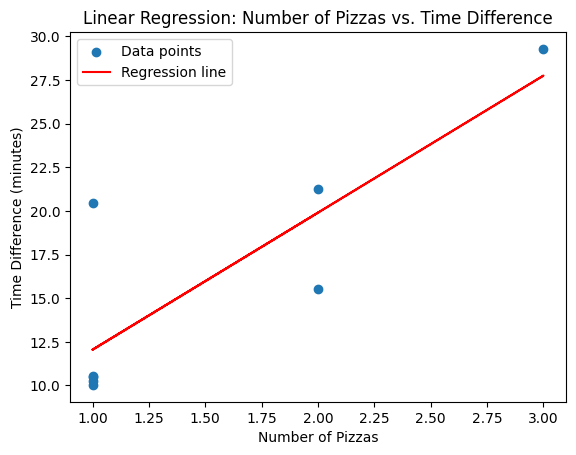

In [169]:
#Python implementation of the regression analysis
    # Using SQL to do the regression is below, but results are largely limited.

# Reformat the data
#X = order_pizza_time_df['num_pizzas']
X = sm.add_constant(order_pizza_time_df['num_pizzas'])
y = pd.to_numeric(order_pizza_time_df["time_diff_min"])

X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
r2 = model.rsquared
slope = model.params['num_pizzas']
intercept = model.params['const']
print(f"Regression line R^2: {r2:.3f}, Intercept: {intercept:.1f}, Slope: {slope:.2f}")

# Plot the data points
plt.scatter(order_pizza_time_df['num_pizzas'], order_pizza_time_df['time_diff_min'], label='Data points')

# Plot the regression line
plt.plot(order_pizza_time_df['num_pizzas'], model.predict(X), color='red', label='Regression line')

plt.xlabel('Number of Pizzas')
plt.ylabel('Time Difference (minutes)')
plt.title('Linear Regression: Number of Pizzas vs. Time Difference')
plt.legend()

plt.show()

In [158]:
query = """
    WITH order_pizza_time AS (
        SELECT 
            co.order_id,
            COUNT(co.pizza_id) AS num_pizzas,
            ROUND(EXTRACT(EPOCH FROM (TO_TIMESTAMP(ro.pickup_time, 'YYYY-MM-DD HH24:MI:SS') - co.order_time)) / 60, 2) AS time_diff_min
        FROM customer_orders AS co
        JOIN runner_orders AS ro ON co.order_id = ro.order_id
        WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
            OR ro.cancellation IS NULL)
        GROUP BY co.order_id, ro.pickup_time, co.order_time
    )
    SELECT 
        REGR_R2(num_pizzas, time_diff_min) AS r2,
        REGR_SLOPE(num_pizzas, time_diff_min) AS slope,
        REGR_INTERCEPT(num_pizzas, time_diff_min) AS intercept
    FROM order_pizza_time
    ;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

regression_stats_df = pd.DataFrame(sql_table, columns=column_names)
regression_stats_df

,r2,slope,intercept
0,0.698528,0.08897,0.078589


What was the average distance travelled for each customer?


In [184]:
query = """
    SELECT 
        co.customer_id, 
        AVG(CAST(REGEXP_REPLACE(ro.distance, '[^0-9.]', '', 'g') AS FLOAT)) AS avg_distance_numeric    
    FROM runner_orders AS ro
    JOIN customer_orders AS co ON ro.order_id = co.order_id
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    GROUP BY co.customer_id
    ORDER BY co.customer_id
    ;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

avg_cust_dist_df = pd.DataFrame(sql_table, columns=column_names)
avg_cust_dist_df

,customer_id,avg_distance_numeric
0,101,20.000000
1,102,16.733333
2,103,23.400000
3,104,10.000000
4,105,25.000000


What was the difference between the longest and shortest delivery times for all orders?


In [187]:
query = """
    SELECT 
        MAX(CAST(REGEXP_REPLACE(ro.duration, '[^0-9.]', '', 'g') AS FLOAT)) - 
        MIN(CAST(REGEXP_REPLACE(ro.duration, '[^0-9.]', '', 'g') AS FLOAT)) AS duration_diff
    FROM runner_orders AS ro
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    ;
    """

cursor.execute(sql.SQL(query))
dur_diff = cursor.fetchone()[0]

print(f"The difference between the longest and shortest delivery times is {dur_diff} minutes.")

The difference between the longest and shortest delivery times is 30.0 minutes.


What was the average speed for each runner for each delivery and do you notice any trend for these values?


In [188]:
query = """
    SELECT 
        ro.runner_id,
        AVG(CAST(REGEXP_REPLACE(ro.distance, '[^0-9.]', '', 'g') AS FLOAT) / 
            CAST(REGEXP_REPLACE(ro.duration, '[^0-9.]', '', 'g') AS FLOAT)) AS avg_speed
    FROM runner_orders AS ro
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    GROUP BY ro.runner_id
    ORDER BY ro.runner_id
    ;
    """



cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

avg_runner_spd_df = pd.DataFrame(sql_table, columns=column_names)
avg_runner_spd_df

,runner_id,avg_speed
0,1,0.758935
1,2,1.048333
2,3,0.666667


In [195]:
query = """
    SELECT 
        ro.runner_id,
        ro.order_id,
        CAST(REGEXP_REPLACE(ro.distance, '[^0-9.]', '', 'g') AS FLOAT) / 
            CAST(REGEXP_REPLACE(ro.duration, '[^0-9.]', '', 'g') AS FLOAT) AS deliv_speed
    FROM runner_orders AS ro
    WHERE (ro.cancellation NOT LIKE '%Cancellation%' 
        OR ro.cancellation IS NULL)
    ;
    """



cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

deliv_spd_df = pd.DataFrame(sql_table, columns=column_names)
deliv_spd_df

,runner_id,order_id,deliv_speed
0,1,1,0.625000
1,1,2,0.740741
2,1,3,0.670000
3,2,4,0.585000
4,3,5,0.666667
5,2,7,1.000000
6,2,8,1.560000
7,1,10,1.000000


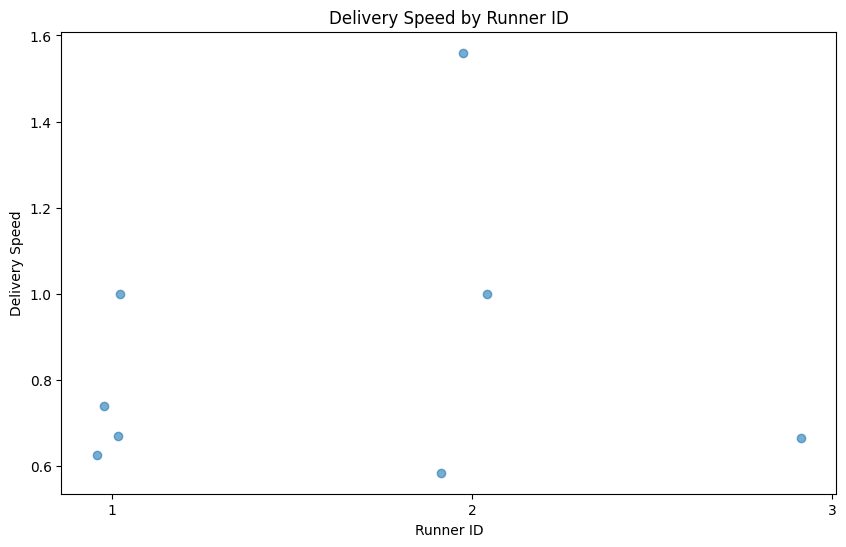

In [194]:
runner_ids = deliv_spd_df['runner_id']
delivery_speeds = deliv_spd_df['deliv_speed']

# Add jitter 
jitter = 0.1
jittered_runner_ids = runner_ids + np.random.uniform(-jitter, jitter, size=len(runner_ids))

plt.figure(figsize=(10, 6))
plt.scatter(jittered_runner_ids, delivery_speeds, alpha=0.6)

plt.xlabel('Runner ID')
plt.ylabel('Delivery Speed')
plt.title('Delivery Speed by Runner ID')
plt.xticks(ticks=np.unique(runner_ids), labels=np.unique(runner_ids))

plt.show()

*The graph suggests that runner 1 is consistently fast ~0.75 km/min with the only delivery for runner 3 is about the same. Runner 2 however has a wide range of speed across the deliveries, which seems to be increasing with each order delivered. Further exploration showed that runner 2's last order was cancelled by the customer indicating that runner 2 may be having trouble delivering orders.*

What is the successful delivery percentage for each runner?

In [196]:
query = """
    SELECT 
        ro.runner_id,
        COUNT(*) AS total_deliveries,
        COUNT(CASE WHEN ro.cancellation IS NULL OR ro.cancellation NOT LIKE '%Cancellation%' THEN 1 END) AS successful_deliveries,
        ROUND(
            COUNT(CASE WHEN ro.cancellation IS NULL OR ro.cancellation NOT LIKE '%Cancellation%' THEN 1 END) * 100.0 / COUNT(*), 
            2
        ) AS success_percentage
    FROM runner_orders AS ro
    GROUP BY ro.runner_id
    ORDER BY ro.runner_id
    ;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

deliv_suc_df = pd.DataFrame(sql_table, columns=column_names)
deliv_suc_df

,runner_id,total_deliveries,successful_deliveries,success_percentage
0,1,4,4,100.00
1,2,4,3,75.00
2,3,2,1,50.00


---
## C. Ingredient Opitimization

What are the standard ingredients for each pizza?


In [246]:
query = """
    WITH tmp_table AS (
        SELECT 
            pizza_id,
            UNNEST(STRING_TO_ARRAY(toppings, ','))::INTEGER AS topping_id
        FROM pizza_recipes AS pr
    )
    SELECT 
        tmp_table.pizza_id,
        pn.pizza_name,
        STRING_AGG(CAST(topping_name AS VARCHAR), ', ') AS toppings_list
    FROM tmp_table
    JOIN pizza_toppings AS pt ON pt.topping_id = tmp_table.topping_id
    JOIN pizza_names AS pn ON pn.pizza_id = tmp_table.pizza_id
    GROUP BY tmp_table.pizza_id, pn.pizza_name
    ORDER BY tmp_table.pizza_id
    ;
    """

cursor.execute(sql.SQL(query))
sql_table = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]

pizza_ingr_df = pd.DataFrame(sql_table, columns=column_names)
pizza_ingr_df

,pizza_id,pizza_name,toppings_list
0,1,Meatlovers,"BBQ Sauce, Pepperoni, Cheese, Salami, Chicken,..."
1,2,Vegetarian,"Tomato Sauce, Cheese, Mushrooms, Onions, Peppe..."


What was the most commonly added extra?


In [257]:
query = """
    WITH tmp_table AS (
        SELECT 
            UNNEST(STRING_TO_ARRAY(co.extras, ', '))::INTEGER AS topping_id
        FROM customer_orders AS co
        WHERE co.extras IS NOT NULL
            AND co.extras NOT LIKE '%null%'
    )
    SELECT pt.topping_name, COUNT(*) AS count
    FROM tmp_table
    JOIN pizza_toppings AS pt ON pt.topping_id = tmp_table.topping_id
    GROUP BY pt.topping_name
    ORDER BY count DESC
    LIMIT 1
    ;
    """

cursor.execute(query)
most_common_topping = cursor.fetchone()[0]

print(f"The most common extra topping is {most_common_topping}.")

The most common extra topping is Bacon.


What was the most common exclusion?


In [258]:
query = """
    WITH tmp_table AS (
        SELECT 
            UNNEST(STRING_TO_ARRAY(co.exclusions, ', '))::INTEGER AS topping_id
        FROM customer_orders AS co
        WHERE co.exclusions IS NOT NULL
            AND co.exclusions NOT LIKE '%null%'
    )
    SELECT pt.topping_name, COUNT(*) AS count
    FROM tmp_table
    JOIN pizza_toppings AS pt ON pt.topping_id = tmp_table.topping_id
    GROUP BY pt.topping_name
    ORDER BY count DESC
    LIMIT 1
    ;
    """

cursor.execute(query)
most_common_excl_topping = cursor.fetchone()[0]

print(f"The most common topping excluded is {most_common_excl_topping}.")

The most common topping excluded is Cheese.


Generate an order item for each record in the customers_orders table in the format of one of the following:
- Meat Lovers
- Meat Lovers - Exclude Beef
- Meat Lovers - Extra Bacon
- Meat Lovers - Exclude Cheese, Bacon - Extra Mushroom, Peppers


Generate an alphabetically ordered comma separated ingredient list for each pizza order from the customer_orders table and add a 2x in front of any relevant ingredients
- For example: "Meat Lovers: 2xBacon, Beef, ... , Salami"


What is the total quantity of each ingredient used in all delivered pizzas sorted by most frequent first?

---
## D. Pricing and Ratings

If a Meat Lovers pizza costs $12 and Vegetarian costs $10 and there were no charges for changes - how much money has Pizza Runner made so far if there are no delivery fees?


What if there was an additional $1 charge for any pizza extras?
- Add cheese is $1 extra


The Pizza Runner team now wants to add an additional ratings system that allows customers to rate their runner, how would you design an additional table for this new dataset - generate a schema for this new table and insert your own data for ratings for each successful customer order between 1 to 5.


Using your newly generated table - can you join all of the information together to form a table which has the following information for successful deliveries?
- customer_id
- order_id
- runner_id
- rating
- order_time
- pickup_time
- Time between order and pickup
- Delivery duration
- Average speed
- Total number of pizzas


If a Meat Lovers pizza was $12 and Vegetarian $10 fixed prices with no cost for extras and each runner is paid $0.30 per kilometre traveled - how much money does Pizza Runner have left over after these deliveries?

---
## E. Table Injection 

If Danny wants to expand his range of pizzas - how would this impact the existing data design? Write an INSERT statement to demonstrate what would happen if a new Supreme pizza with all the toppings was added to the Pizza Runner menu?